# Imports

In [1]:
import numpy as np
import pandas as pd
from pulsee.operators import * 
from pulsee.simulation import *
import qutip as qt
import matplotlib.pyplot as plt

# Parameters

In [42]:
qn = 3/2
gr = 11.26
b0 = 10.
e2qQ = 0.5

spin_par = {'quantum number' : qn,
			'gamma/2pi' : gr}

zeem_par = {'field magnitude' : b0,
			'theta_z' : 0,
			'phi_z' : 0}

In [3]:
etas = np.linspace(0, 1, 4)

# Simulation
Define simulation code which we will run with different solvers:

In [36]:
def simulate(solver):

    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : math.pi/2*0,
                    'gamma_q' : 0.}

        b1 = 1e-2 * b0

        mode = pd.DataFrame([(2 * np.pi * gr * b0, 2 * b1, 0., math.pi/2, 0)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

        RRF_par = {'nu_RRF': 2 * np.pi * gr * b0,
                    'theta_RRF': math.pi,
                    'phi_RRF': 0.}

#         dm_initial = Qobj([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
                                            zeem_par=zeem_par, initial_state='canonical')

        dm_evolved = evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, pulse_time=1 / (4 * gr * b1), \
                            picture='IP', n_points=10)

        t, FID = FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=50, \
                T2=10, reference_frequency=gr*b0, n_points=10)


        f, ft = fourier_transform_signal(FID, t, padding=10)
        fts.append([eta, f, ft])
    return fts

Run simulations with Magnus solver and QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve):

In [37]:
fts_magnus = simulate('magnus')

In [51]:
def simulate(solver):

    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : math.pi/2*0,
                    'gamma_q' : 0.}

        b1 = 1e-2 * b0

        mode = pd.DataFrame([(2 * np.pi * gr * b0, 2 * b1, 0., math.pi/2, 0)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

        RRF_par = {'nu_RRF': 2 * np.pi * gr * b0,
                    'theta_RRF': math.pi,
                    'phi_RRF': 0.}

#         dm_initial = Qobj([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
                                            zeem_par=zeem_par, initial_state='canonical')

        dm_evolved = evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, pulse_time=1 / (4 * gr * b1), \
                            picture='IP', n_points=100)
        print(1)
        t, FID = FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=100, \
                T2=100, reference_frequency=gr*b0, n_points=100)


        f, ft = fourier_transform_signal(FID, t, padding=10)
        fts.append([eta, f, ft])
    return fts

In [52]:
fts_mesolve = simulate('mesolve')

1
1
1
1


Simulate with exact diagonalization approach:

In [20]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : math.pi/2,
				'gamma_q' : 0.}

	b1 = 1e-2 * b0

	RRF_par = {'nu_RRF': 2 * np.pi * gr * b0,
				'theta_RRF': math.pi,
				'phi_RRF': 0.}

# 	dm_initial = Qobj([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical')



	t = np.linspace(0, 50, 100) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	rot_dm = apply_rot_pulse(dm_initial, 1 / (4 * gr * b1), ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True)

	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=10)
	fts_ed.append([eta, f, ft])


# Plots
Plot magnus solution:

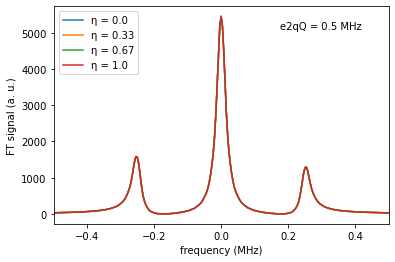

In [41]:
fig, ax = plt.subplots()
for eta, f, ft in fts_magnus:
    plt.xlim(-0.5,0.5)
    plt.plot(f, np.absolute(ft)**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")

plt.show()

Plot mesolve solution:

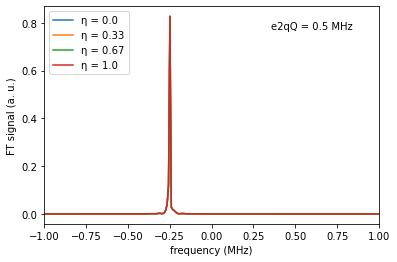

In [53]:
fig, ax = plt.subplots()
for eta, f, ft in fts_mesolve:
    plt.xlim(-1, 1)
    plt.plot(f, np.absolute(ft)**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")

plt.show()


Plot exact diagonalization solution:

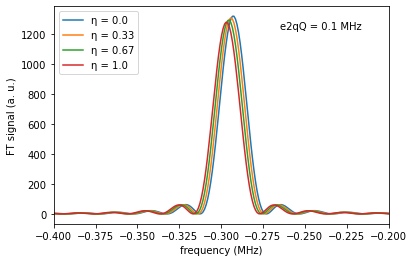

In [17]:
fig, ax = plt.subplots()
for eta, f, ft in fts_ed:
    plt.xlim(-0.4, -.2)
    plt.plot(f, np.absolute(ft)**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")

plt.show()
